In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
In_Colab = True
try:
  from google.colab import drive
except ImportError:
  In_Colab =  False

In [7]:
if In_Colab:
  drive.mount('/content/drive')
  data_path = "/content/drive/MyDrive/DLLab1"
else:
  data_path = "/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_csv(os.path.join(data_path, "train.xls"))

X = data.drop(columns=['price_range'])
y = data['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print("Train Data:")
print(X_train.columns)

Train Data:
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


In [9]:
print("Train len: ", len(X_train))
print("Test len: ", len(X_test))

Train len:  1400
Test len:  600


In [10]:
missing_values = X_train.isnull().sum()
print("Пропущені значення у датасеті:")
print(missing_values[missing_values > 0])

Пропущені значення у датасеті:
Series([], dtype: int64)


In [11]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

print("Категоріальні змінні:", len(categorical_cols), categorical_cols)
print("Числові змінні:", len(numerical_cols), numerical_cols)

Категоріальні змінні: 0 []
Числові змінні: 20 ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi']


In [12]:
unique_counts = X_train.nunique()
print("Кількість унікальних значень у кожному стовпці:")
print(unique_counts)

low_unique_cols = unique_counts[unique_counts < 5].index.tolist()

print("\nСтовпці, що потенційно є категоріальними:")
print(low_unique_cols)


Кількість унікальних значень у кожному стовпці:
battery_power     919
blue                2
clock_speed        26
dual_sim            2
fc                 19
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height         930
px_width          917
ram              1166
sc_h               15
sc_w               19
talk_time          19
three_g             2
touch_screen        2
wifi                2
dtype: int64

Стовпці, що потенційно є категоріальними:
['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']


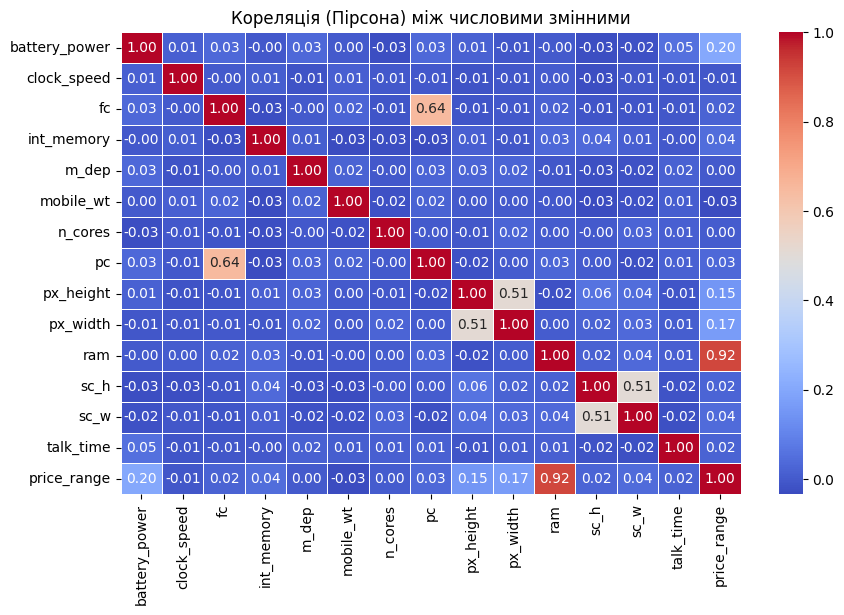

In [65]:
all_columns = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
               'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
               'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
               'touch_screen', 'wifi', 'price_range']

binary_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

non_binary_columns = [col for col in all_columns if col not in binary_columns]

# Побудова кореляційної матриці
plt.figure(figsize=(10, 6))
sns.heatmap(data[non_binary_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Кореляція (Пірсона) між числовими змінними")
plt.show()

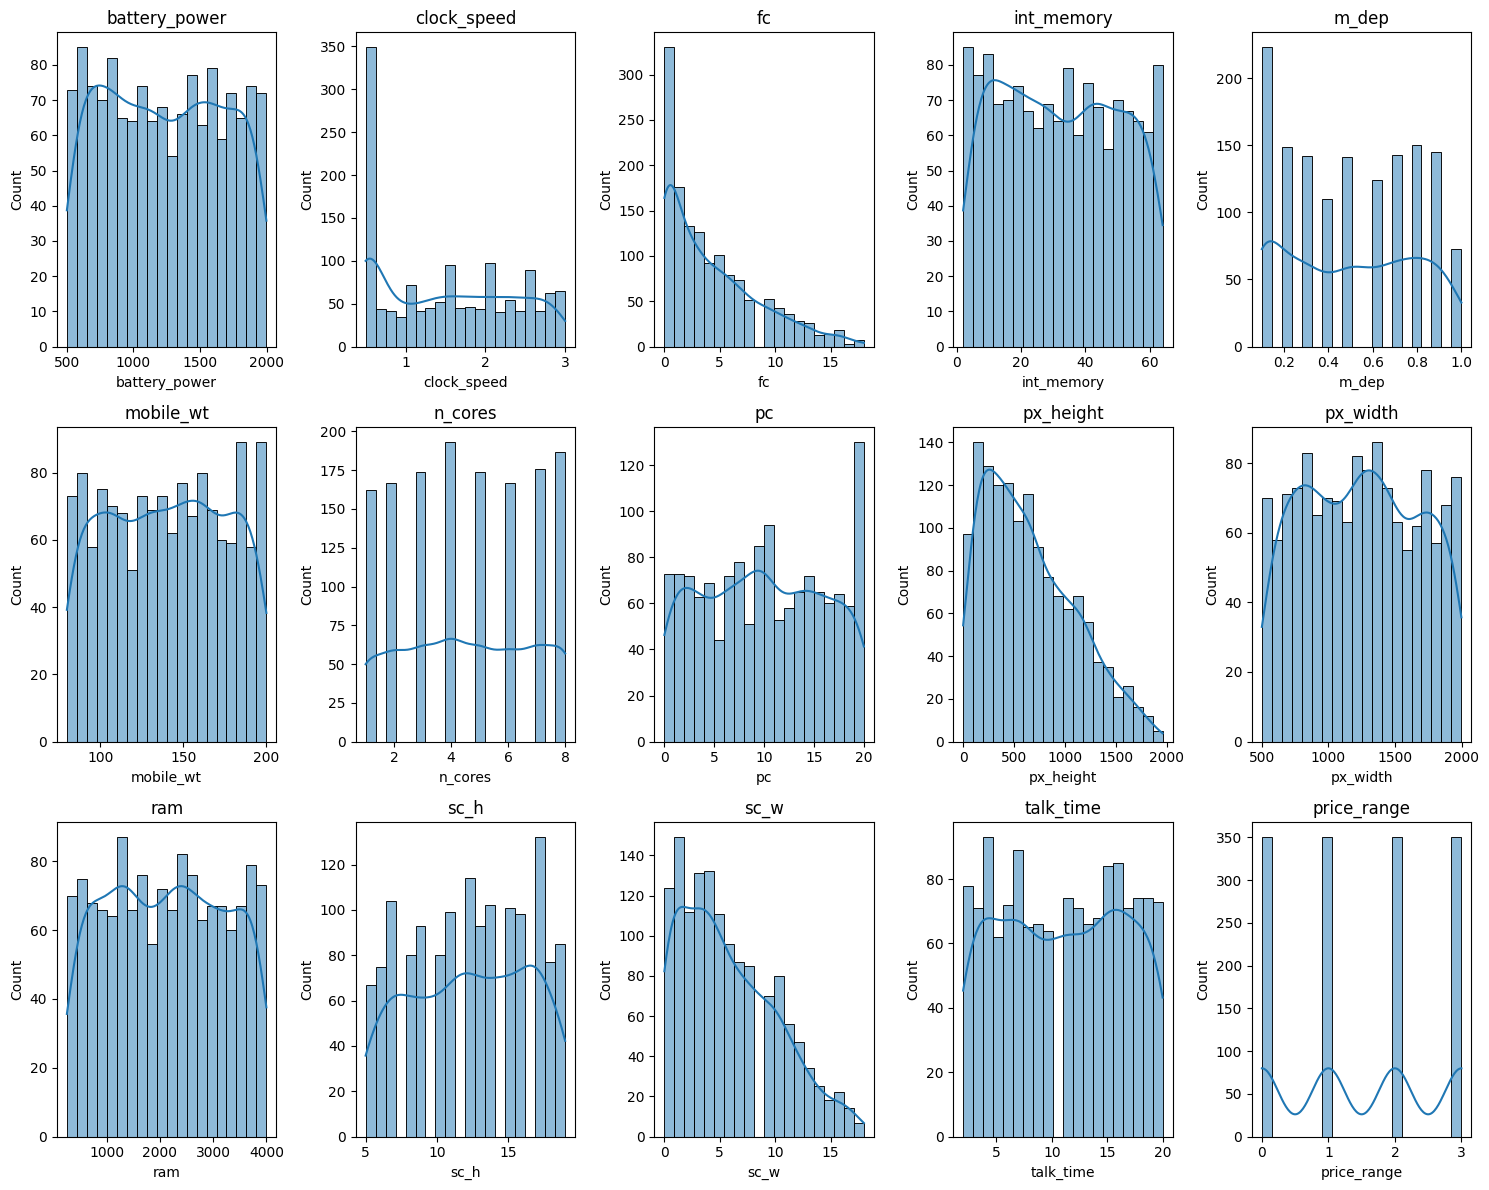

In [14]:
num_cols = len(non_binary_columns)
cols_per_row = 5
rows = -(-num_cols // cols_per_row)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(non_binary_columns):
  if col != 'price_range':
    sns.histplot(X_train[col], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"{col}")
  else:
    sns.histplot(y_train, kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"{col}")

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


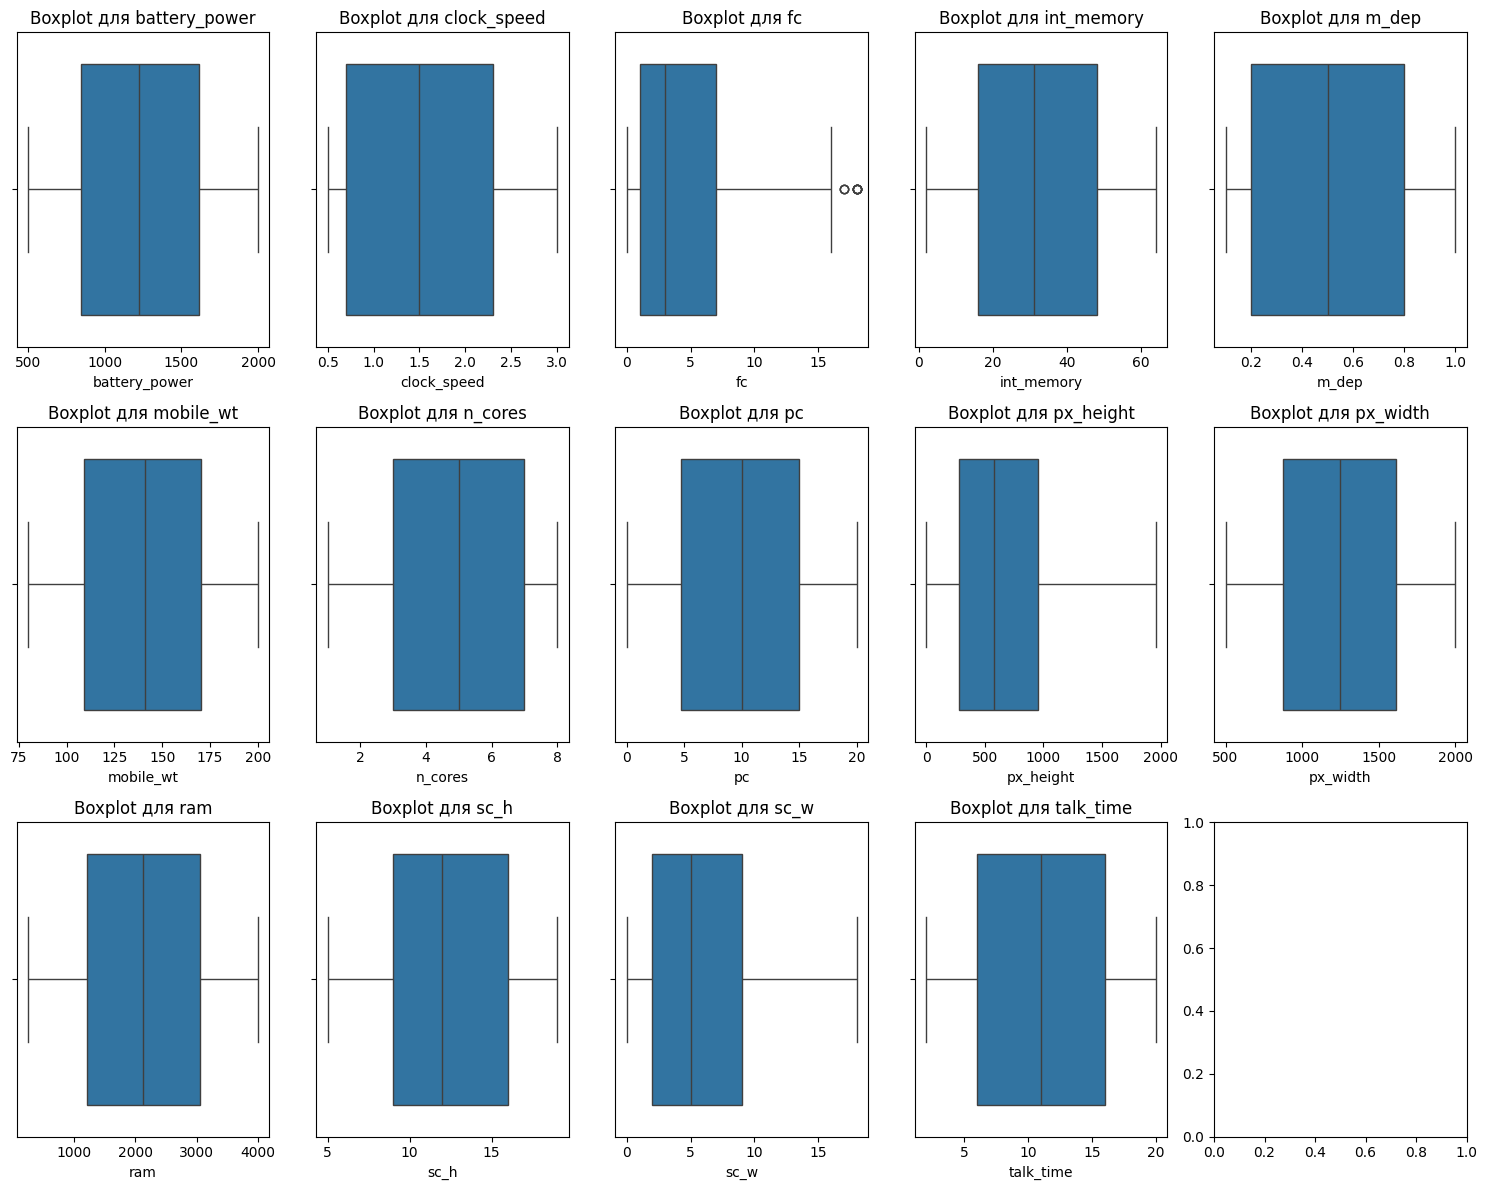

In [15]:
num_cols = len(non_binary_columns)
cols_per_row = 5
rows = -(-num_cols // cols_per_row)
fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, rows * 4))
axes = axes.flatten()

for i, col in enumerate(non_binary_columns):
  if col != 'price_range':
    sns.boxplot(x=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot для {col}")

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [16]:
X_pca = PCA(n_components=3).fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
pca_df["price_range"] = y

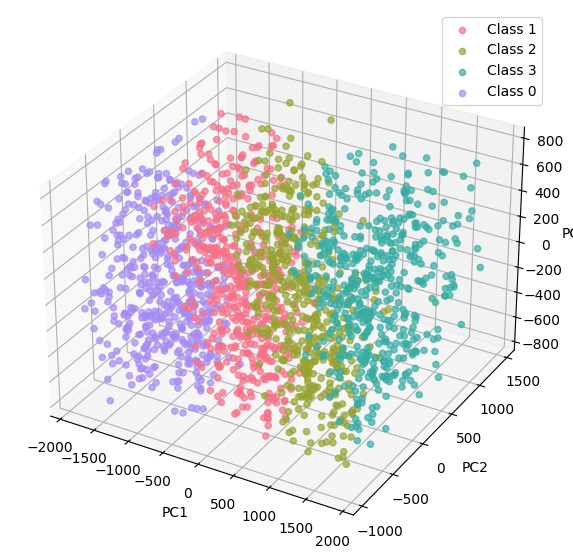

In [17]:
colors = sns.color_palette("husl", len(y.unique()))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

for label, color in zip(y.unique(), colors):
    subset = pca_df[pca_df["price_range"] == label]
    ax.scatter(subset["PC1"], subset["PC2"], subset["PC3"], label=f"Class {label}", color=color, alpha=0.7)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

ax.legend()
plt.show()


In [90]:
results = {}


def evaluate_model(model, name, results, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average="macro")
    results[name] = {"Accuracy": accuracy, "Macro F1": f1_macro}
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2', '3'], yticklabels=['0', '1', '2', '3'])

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show()


Критерій поділу: ram
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       150
           1       0.00      0.00      0.00       150
           2       0.00      0.00      0.00       150
           3       0.51      1.00      0.68       150

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



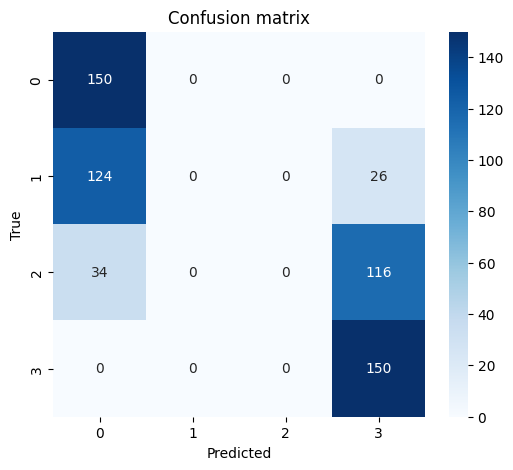

In [91]:
one_rule = DecisionTreeClassifier(max_depth=1)
one_rule.fit(X_train, y_train)
print('Критерій поділу:', one_rule.feature_names_in_[one_rule.feature_importances_>0][0])
evaluate_model(one_rule, "1-Rule", results, X_test, y_test)


              precision    recall  f1-score   support

           0       0.93      0.92      0.93       150
           1       0.72      0.69      0.70       150
           2       0.66      0.69      0.67       150
           3       0.88      0.89      0.88       150

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



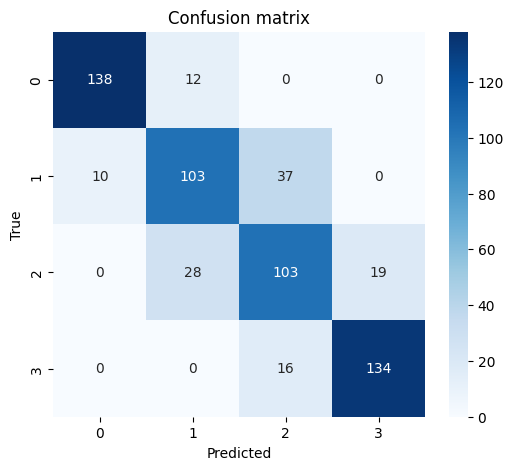

In [92]:
nb = GaussianNB()
nb.fit(X_train, y_train)

evaluate_model(nb, "Naive Bayes", results, X_test, y_test)

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       150
           1       0.79      0.75      0.77       150
           2       0.74      0.74      0.74       150
           3       0.84      0.89      0.86       150

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



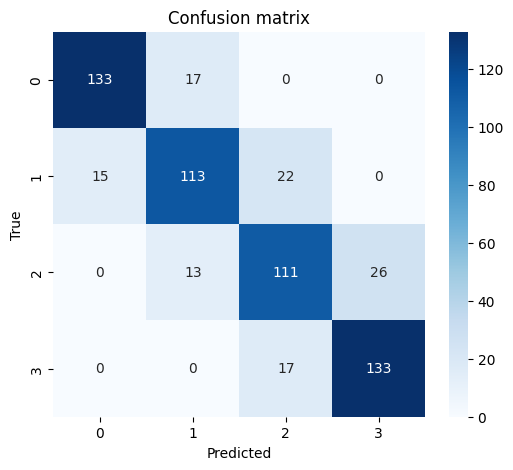

In [93]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

evaluate_model(dt, "Decision Tree", results, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       150
           1       0.93      0.93      0.93       150
           2       0.89      0.89      0.89       150
           3       0.94      0.93      0.93       150

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



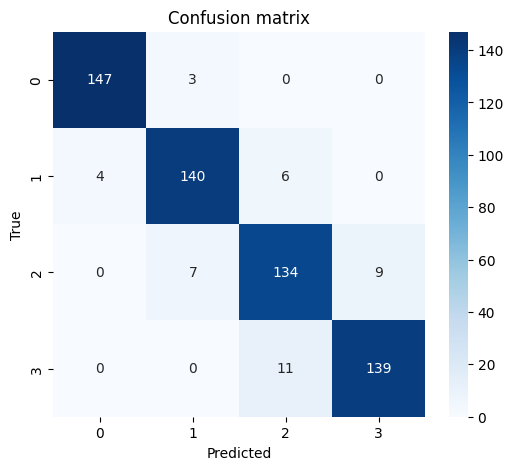

In [94]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

evaluate_model(knn, "kNN", results, X_test, y_test)

In [95]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print(results_df)

               Accuracy  Macro F1
kNN            0.933333  0.933332
Decision Tree  0.816667  0.816197
Naive Bayes    0.796667  0.796734
1-Rule         0.500000  0.333439


In [96]:
def search_for_params(model, param_dist_nb, X, y):
  random_search_nb = RandomizedSearchCV(model, param_distributions=param_dist_nb, n_iter=20, cv=4, scoring='accuracy', random_state=42)
  random_search_nb.fit(X, y)

  best_nb = random_search_nb.best_estimator_
  y_pred_nb = best_nb.predict(X)
  accuracy_nb = accuracy_score(y, y_pred_nb)
  f1_macro_nb = f1_score(y, y_pred_nb, average='macro')
  return random_search_nb.best_params_, accuracy_nb, f1_macro_nb


In [97]:
model = GaussianNB()
param_dist = {
    'var_smoothing': np.logspace(-9, 0, 10)
}

params_nb, accuracy_nb, f1_macro_nb = search_for_params(model, param_dist, X_train, y_train)
print("Naive Bayes: Найкращі параметри:", params_nb)
print(f"Naive Bayes: Accuracy = {accuracy_nb:.4f}, Macro F1 = {f1_macro_nb:.4f}")

Naive Bayes: Найкращі параметри: {'var_smoothing': 1e-08}
Naive Bayes: Accuracy = 0.8164, Macro F1 = 0.8169


In [98]:
model = DecisionTreeClassifier()

param_dist = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'random_state': [42]
}

params_dt, accuracy_dt, f1_macro_dt = search_for_params(model,  param_dist, X_train, y_train)
print("Decision Tree: Найкращі параметри:", params_dt)
print(f"Decision Tree: Accuracy = {accuracy_dt:.4f}, Macro F1 = {f1_macro_dt:.4f}")

Decision Tree: Найкращі параметри: {'random_state': 42, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10}
Decision Tree: Accuracy = 0.9014, Macro F1 = 0.9013


In [99]:
model = KNeighborsClassifier()

param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

params_knn, accuracy_knn, f1_macro_knn = search_for_params(model,  param_dist, X_train, y_train)
print("KNN: Найкращі параметри:", params_knn)
print(f"KNN: Accuracy = {accuracy_knn:.4f}, Macro F1 = {f1_macro_knn:.4f}")

KNN: Найкращі параметри: {'weights': 'uniform', 'p': 2, 'n_neighbors': 7}
KNN: Accuracy = 0.9450, Macro F1 = 0.9451


              precision    recall  f1-score   support

           0       0.91      0.90      0.91       500
           1       0.73      0.72      0.73       500
           2       0.71      0.73      0.72       500
           3       0.90      0.89      0.89       500

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000



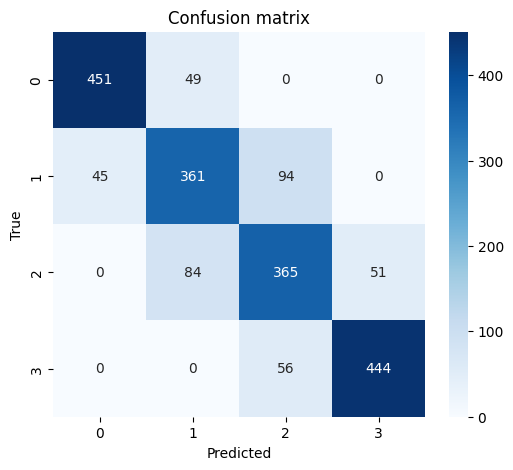

In [100]:
nb = GaussianNB(**params_nb)
nb.fit(X_train, y_train)

evaluate_model(nb, "Tuned Naive Bayes", results, X, y)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       150
           1       0.78      0.83      0.81       150
           2       0.80      0.71      0.76       150
           3       0.85      0.93      0.89       150

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



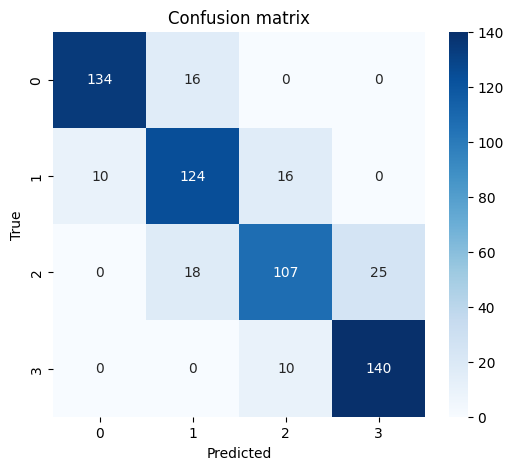

In [101]:
dt = DecisionTreeClassifier(**params_dt)
dt.fit(X_train, y_train)

evaluate_model(dt, "Tuned Decision Tree", results, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       150
           1       0.93      0.95      0.94       150
           2       0.90      0.91      0.90       150
           3       0.95      0.93      0.94       150

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



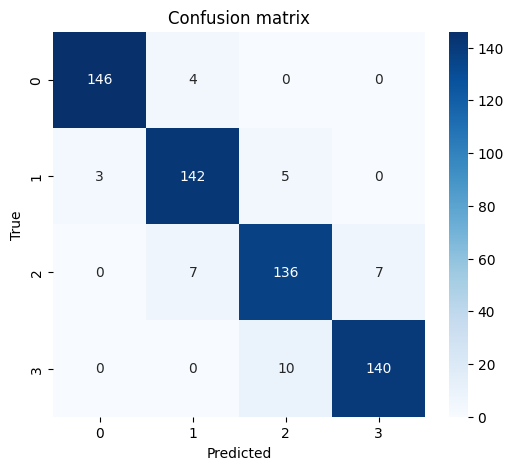

In [102]:
knn = KNeighborsClassifier(**params_knn)
knn.fit(X_train, y_train)

evaluate_model(knn, "Tuned kNN", results, X_test, y_test)

In [103]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print(results_df)

                     Accuracy  Macro F1
Tuned kNN            0.940000  0.940074
kNN                  0.933333  0.933332
Tuned Decision Tree  0.841667  0.840458
Decision Tree        0.816667  0.816197
Tuned Naive Bayes    0.810500  0.810914
Naive Bayes          0.796667  0.796734
1-Rule               0.500000  0.333439
